In [1]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

In [17]:
def generate_niche_model(S, C):
    """
    Inputs 
        S = number of species
        C = connectance = L / S**2 (proportion of possible links filled)
    """

    L = C * S**2

    # 1. Get the niche value n_i for each species
    niche_values = np.sort(np.random.uniform(low=0, high=1, size=S))

    # 2. Define the predation breadth r_i
    # First the alpha and beta values picked so that the mean of the beta distribution is 2C
    # 1 / 1 + b = 2C --> b = (1 - 2C) / 2C
    b = (1 - 2 * C) / (2 * C)

    niche_breadths = niche_values * 2 * np.random.beta(1, b, size=S)

    # Pick the niche centers
    niche_centers = np.random.uniform(low=niche_breadths/2, high=niche_values, size=S)

    # Create the interaction matrix
    A = np.zeros((S, S), dtype=int)
    for i in range(1, S): # Start at 1 so that species 0 is default autotroph
        A[i] = (
            (niche_values < niche_centers[i] + niche_breadths[i] / 2) & 
            (niche_values > niche_centers[i] - niche_breadths[i] / 2)
        ).astype(np.int64)

    G = nx.from_numpy_array(A, create_using=nx.DiGraph)
    cycles = nx.simple_cycles(G)
    try:    
        cycle = next(cycles)
    except StopIteration:
        cycle = []
    found_cycle = (len(cycle) > 1)
    if found_cycle:
        print(f"found cycle {cycle}; recalculating...")
    if (not nx.is_connected(G.to_undirected())) or found_cycle:
        A, niche_values, niche_centers, niche_breadths = generate_niche_model(S, C)
        return A, niche_values, niche_centers, niche_breadths
    else:
        return A, niche_values, niche_centers, niche_breadths

def trophic_levels(A):

    N = len(A)
    T = np.zeros(N)
    T_new = (A * T).mean(1) + 1
    while not np.all(T_new == T):
        T = T_new.copy()
        A_T = (A * T)
        np.fill_diagonal(A_T, 0)
        with np.errstate(divide='ignore'):
            T_new = A_T.sum(1) / A.sum(1) + 1
        T_new[np.isnan(T_new)] = 1

    return T_new
        

def plot(A, niche_values, niche_centers=None, niche_breadths=None, highlight=None):

    fig, (top, bottom) = plt.subplots(2,1, figsize=(5,6), height_ratios=[3, 1])

    N = len(A)
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)
    pos = nx.spring_layout(G, iterations=10)
    T = trophic_levels(A)
    for iter in range(10):
        pos_new = nx.spring_layout(G, pos=pos, iterations=100, scale=2)
        for i in pos_new:
            pos_new[i][1] = T[i]
        pos = pos_new

    nodes = nx.draw_networkx_nodes(G, pos=pos, ax=top, node_size=100, label=True)
    nodes.set_edgecolor('k')
    edges = nx.draw_networkx_edges(G, pos=pos, ax=top, alpha=0.1)

    bottom.plot(niche_values, [0.12]*N, 'v', mec='k', ms=10)
    bottom.hlines(0, 1, 0, color='k')
    bottom.set_ylim(-1, 1)
    bottom.xaxis.set_visible(False)
    bottom.yaxis.set_visible(False)

    if highlight is not None:
        assert isinstance(highlight, int) and (highlight in G), ValueError("highlight must be int node index")

        neighbors = [e[1] for e in G.out_edges(highlight)]

        # Highlight the node and its alters
        u = nx.draw_networkx_nodes(G.subgraph(highlight), pos=pos, ax=top, node_size=100, node_color='C1', label=True)
        u.set_edgecolor('k')

        u = nx.draw_networkx_nodes(G.subgraph(neighbors), pos=pos, ax=top, node_size=100, node_color='C0', label=True)
        u.set_edgecolor('C1')

        nx.draw_networkx_edges(nx.ego_graph(G, highlight), pos=pos, ax=top, alpha=1, edge_color='C1')

        c = niche_centers[highlight]
        n = niche_values[highlight]
        r = niche_breadths[highlight]
        # Highlight the niche value
        bottom.plot(n, [0.12], 'v', mec='k', ms=10, c='C1')
        bottom.hlines(-0.2, c - r/2, c+r/2, color='C1')
        bottom.plot([c], [-0.2], marker='+', mfc='C1', mec='C1')
        bottom.plot(niche_values[neighbors], [0.12] * len(neighbors), marker='v', mec='C1', ms=10, mfc='C0', lw=0)
        

/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_86333/200164886.py:56: RuntimeWarning: invalid value encountered in divide
  T_new = A_T.sum(1) / A.sum(1) + 1


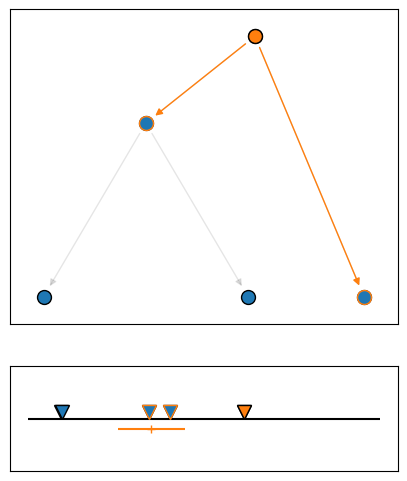

In [18]:
A, niche_values, niche_centers, niche_breadths = generate_niche_model(5, 0.05)
T = trophic_levels(A)
plot(A, niche_values, niche_centers, niche_breadths, 4)

/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_86333/1023188932.py:56: RuntimeWarning: invalid value encountered in divide
  T_new = A_T.sum(1) / A.sum(1) + 1


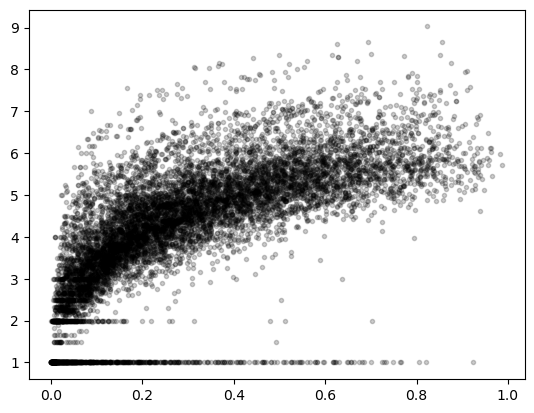

In [12]:
for i in range(100):
    A, niche_values, niche_centers, niche_breadths = generate_niche_model(100, 0.1)
    T = trophic_levels(A)
    plt.plot(niche_centers, T, '.k', alpha=0.2)